## Table of Content

- [1.0 - Packages](#1.0)
- [2.0 - Data Pre-processing](#2.0)
- [3.0 - Model Training](#3.0)
    - [3.1 - Dataloader](#3-1)
    - [3.2 - Transfer Learning with ResNet18](#3-2)
- [4.0 - Model Evaluation](#4.0)
- [5.0 - Image Embedding Retrieval](#5.0)
- [6.0 - Content-Based Image Retrieval](#6.0)
    - [6.1 - ANNOY](#6-1)
    - [6.2 - Recommendations with ANNOY](#6-2)
    - [6.2.1 - K @ 5](#6-2.1)
    - [6.2.2 - K @ 10](#6-2.2)

<a name='1.0'></a>

#### 1.0 PACKAGES

In [ ]:
!pip install fastai
!pip install annoy
!pip install gdown

In [ ]:
import gdown
import zipfile
import time
import torch
import torchvision
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from ast import literal_eval
from PIL import Image, ImageDraw
from functools import partial
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
from google.colab import drive
%matplotlib inline

<a name='2.0'></a>

#### 2.0 DATA PRE-PROCESSING

In [ ]:
root_path = '/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset'

train_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/train_df.csv')
val_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/val_df.csv')
test_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/test_df.csv')

In [ ]:
train_df['file_path'] = root_path + '/train_dataset/' + train_df['filename']
val_df['file_path'] = root_path + '/validation_dataset/' + val_df['filename']
test_df['file_path'] = root_path + '/test_dataset/' + test_df['filename']

In [ ]:
def display_image(file_name):
    try:
        img = Image.open(file_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"An error occured: {e}")

In [ ]:
display_image(test_df['file_path'][999])
display_image(test_df['file_path'][20])
display_image(val_df['file_path'][50])

In [ ]:
combined_df = pd.concat([train_df, val_df])

category_count = combined_df['category'].value_counts()
category_count

<a name='3.0'></a>

### 3.0 MODEL TRAINING

<a name='3-1'></a>

##### 3.1 Dataloader

In [ ]:
test_size = 0.05

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('file_path'),
                   get_y=ColReader('category'),
                   splitter = TrainTestSplitter(test_size=test_size, random_state=42),
                   item_tfms=Resize(128),
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])


# Create a DataLoaders object for training
dls = dblock.dataloaders(combined_df, bs=128)

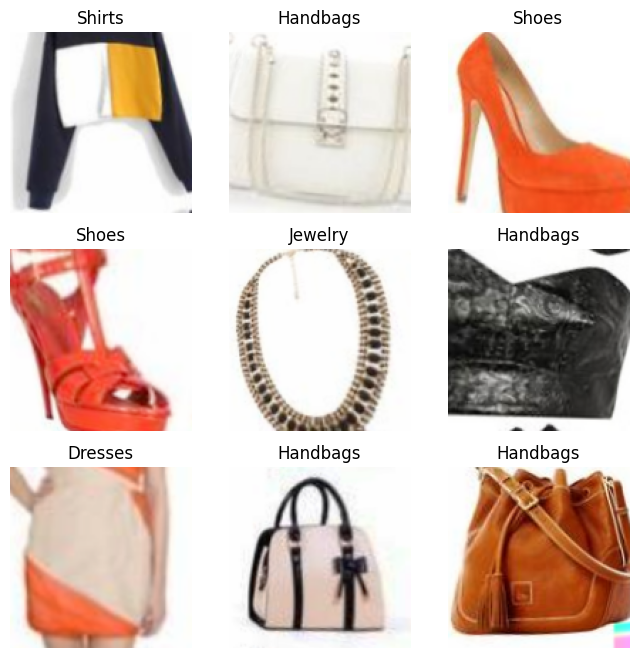

In [ ]:
# Show a batch with the desired settings
dls.show_batch(max_n=9, figsize=(8, 8))

<a name='3-2'></a>

##### 3.2 Transfer Learning with ResNet18

In [ ]:
from functools import partial

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


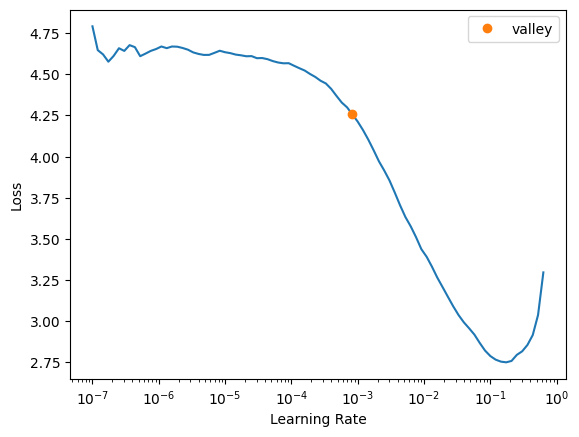

In [ ]:
def train_model(data, pretrained_model, model_metrics):
  learner = vision_learner(data, pretrained_model, metrics=model_metrics)
  learner.model = torch.nn.DataParallel(learner.model)
  learner.lr_find()
  return learner

pretrained_model = models.resnet18

model_metrics = [accuracy, partial(top_k_accuracy, k=1),
                 partial(top_k_accuracy, k=5)]
learner = train_model(dls, pretrained_model, model_metrics)

In [ ]:
learner.fit_one_cycle(10, lr_max=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,0.517459,0.376421,0.880000,0.880000,0.994526,17:10
1,0.486390,0.406046,0.878316,0.878316,0.991579,00:47
2,0.447301,0.353799,0.884211,0.884211,0.994105,00:48
3,0.381350,0.270683,0.912000,0.912000,0.993263,00:47
4,0.346123,0.278039,0.903579,0.903579,0.997053,00:48
5,0.325144,0.241693,0.921684,0.921684,0.997474,00:48
6,0.291622,0.192092,0.940632,0.940632,0.997053,00:48
7,0.265402,0.191150,0.939368,0.939368,0.997895,00:49
8,0.247085,0.187075,0.941474,0.941474,0.997895,00:49
9,0.244266,0.186022,0.942316,0.942316,0.997895,00:50


<a name='4.0'></a>

#### 4.0 MODEL EVALUATION

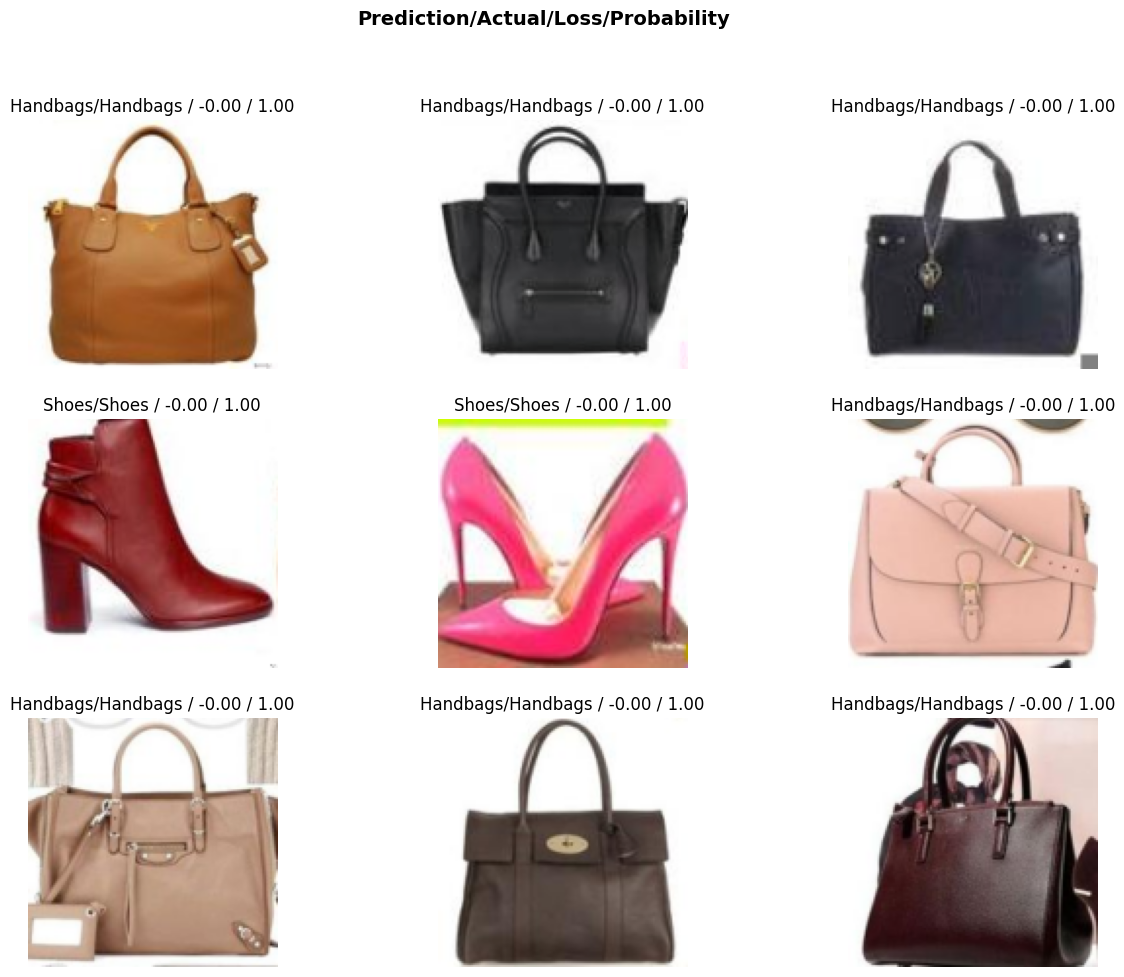

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11))

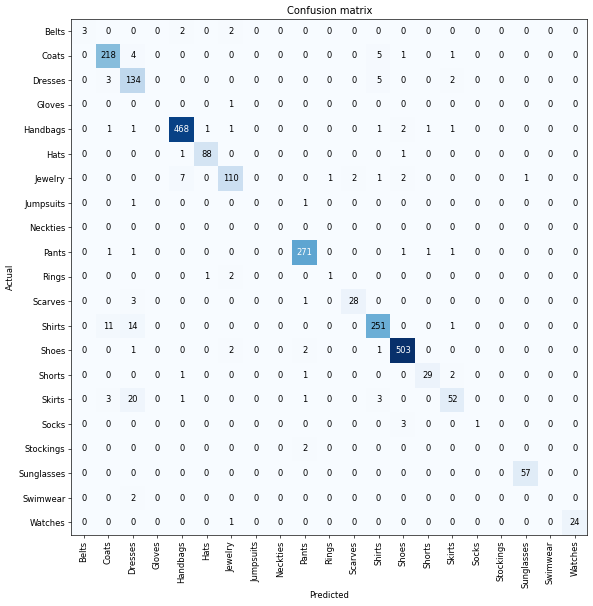

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [ ]:
learner.save('resnet18-ctl')

Path('models/resnet18-ctl.pth')

In [ ]:
# view model details
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

<a name='5.0'></a>

#### 5.0 IMAGE EMBEDDING RETRIEVAL

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self):
        self.hook.remove()

In [ ]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = vision_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

model_path = "/content/models/resnet18-ctl"

learner = load_learner(dls, pretrained_model, model_metrics, model_path)

In [ ]:
saved_features = SaveFeatures(learner.model.module[1][4])
_ = learner.get_preds(dl=dls.train)
_ = learner.get_preds(dl=dls.valid)

In [ ]:
file_paths_train = dls.train.items[dls.cols[0].items].iloc[:, 0].tolist()
file_paths_test = dls.valid.items[dls.cols[0].items].iloc[:, 0].tolist()
file_paths = [str(x) for x in (file_paths_train + file_paths_test)]

In [ ]:
label_paths_train = dls.train.items[dls.cols[1].items].iloc[:, 0].tolist()
label_paths_test = dls.valid.items[dls.cols[1].items].iloc[:, 0].tolist()
label_paths = [str(x) for x in (label_paths_train + label_paths_test)]

In [ ]:
df_output = pd.DataFrame({'img_path': file_paths, 'label': label_paths})
df_output['embeddings'] = np.array(saved_features.features).tolist()

In [ ]:
df_output.head()

In [ ]:
df_output.to_csv('df_output.csv', index=False)

In [ ]:
label_name_to_id = {
    'Pants': 0,
    'Handbags': 1,
    'Shirts': 2,
    'Shoes': 3,
    'Scarves': 4,
    'Jewelry': 5,
    'Skirts': 6,
    'Coats': 7,
    'Hats': 8,
    'Dresses': 9,
    'Shorts': 10,
    'Watches': 11,
    'Sunglasses': 12,
    'Jumpsuits': 13,
    'Socks': 14,
    'Rings': 15,
    'Belts': 16,
    'Gloves': 17,
    'Swimwear': 18,
    'Stockings': 19,
    'Neckties': 20
}

In [ ]:
df_output.to_csv('df_w_emb.csv', index=False)

In [ ]:
# Create a new column 'label_id' based on the mapping by making a copy
df_output['label_id'] = df_output['label'].map(label_name_to_id).copy()
df_output.head()

In [ ]:
df_output = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/df_w_emb.csv')

In [ ]:
# Convert string representations of lists to actual lists
df_output['embeddings'] = df_output['embeddings'].apply(literal_eval)

In [ ]:
df_output['embeddings'].dtype

dtype('O')

<a name='6.0'></a>

#### 6.0 Content-Based Image Retrieval

<a name='6-1'></a>

##### 6.1 ANNOY

In [ ]:
def measure_memory_usage():
    process = psutil.Process()
    start_memory = process.memory_info().rss
    return start_memory

In [ ]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, num_items=12):
  start = time.time()
  img_id, img_label = df_output.iloc[img_index, [0, 1]]
  similar_img_ids = annoy_tree.get_nns_by_item(img_index, num_items + 1)
  end = time.time()
  print(f'{(end - start) * 1000} ms')
  # ignore first item as it's target image
  return img_id, img_label, df_output.iloc[similar_img_ids[1:]]

# for images similar to centroid
def get_similar_images_annoy_centroid(annoy_tree, vector_value, num_items=12):
  start = time.time()
  similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, num_items + 1)
  end = time.time()
  print(f'{(end - start) * 1000} ms')
  # ignore first item as it is always target image
  return df_output.iloc[similar_img_ids[0:]]

In [ ]:
ntree= 50
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(df_output['embeddings'][0]), metric=metric_choice)

for i, vector in enumerate(df_output['embeddings']):
  annoy_tree.add_item(i, vector)

start_memory = measure_memory_usage()
start = time.time()
_ = annoy_tree.build(ntree)
end = time.time()
end_memory = measure_memory_usage()
ram_consumption = end_memory - start_memory
print(f'{(end - start) * 1000} ms')
print(f'RAM Consumption: {ram_consumption / (1024 * 1024)} MB')

615.1037216186523 ms
RAM Consumption: 84.203125 MB


In [ ]:
def centroid_embedding(outfit_embedding_list):
  number_of_outfits = outfit_embedding_list.shape[0]
  length_of_embedding = outfit_embedding_list.shape[1]
  centroid = []
  for i in range(length_of_embedding):
    centroid.append(np.sum(outfit_embedding_list[:, i]) / number_of_outfits)
  return centroid

In [ ]:
def visualize_images(df):
    # Create a figure with two columns
    fig, axs = plt.subplots(5, 2, figsize=(10, 8))

    plt.suptitle("Recommended Items based on your selection", fontsize=16, y=1.03)

    # Display the item selected in the first column (column 0)
    selected_row = df.iloc[0]
    selected_img_path = selected_row.img_path
    selected_label = selected_row.label
    selected_img = mpimg.imread(selected_img_path)
    axs[0, 0].imshow(selected_img)
    axs[0, 0].set_title(f'Item selected: {selected_label}')
    axs[0, 0].axis('off')

    # Loop through the recommended items (remaining rows) and display them in the second column (column 1)
    recommended_items = list(df.iloc[1:].itertuples())
    for i, (row, ax) in enumerate(zip(recommended_items, axs[1:].flatten()), 1):
        img_path = row.img_path
        label = row.label
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f'Recommended: {label}')
        ax.axis('off')

    # Hide the empty subplots
    for i in range(5, 10):
        axs[i // 2, i % 2].axis('off')

    # Hide the axis line in the second column of the first row
    axs[0, 1].axis('off')

    # Show the images
    plt.show()

<a name='6-2'></a>

##### 6.2 Recommendations with ANNOY

<a name='6-2.1'></a>

##### 6.2.1 K @ 5

12501


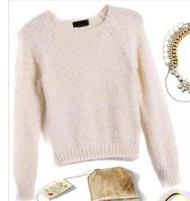

In [ ]:
# explore images
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id = [12501]
outfit_embedding_list = []
for img_index in outfit_img_id:
  outfit_embedding_list.append(df_output.iloc[img_index, 2])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = df_output.iloc[outfit_img_id]

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 6)

0.9572505950927734 ms


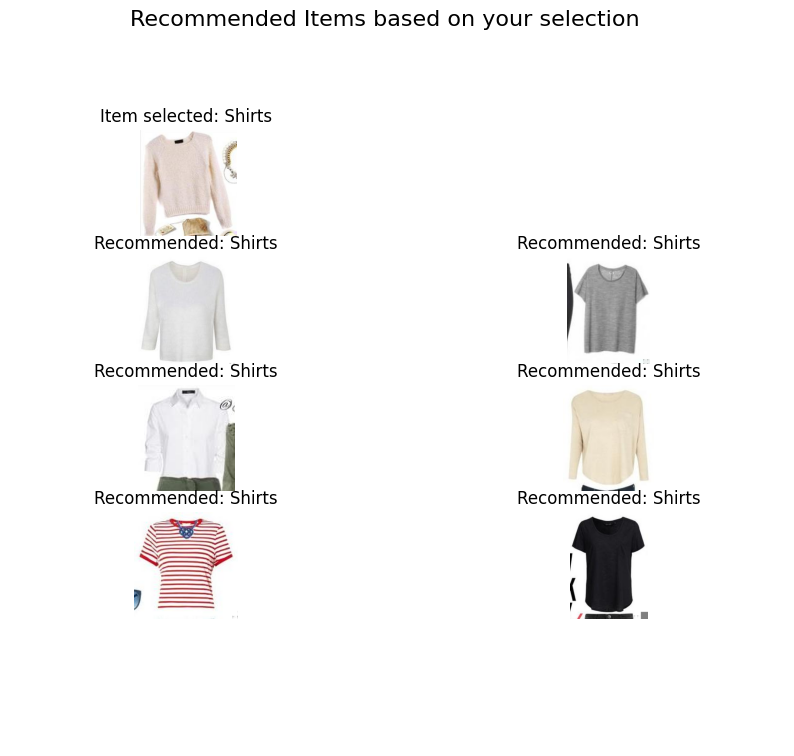

In [ ]:
visualize_images(similar_images_df)

26754


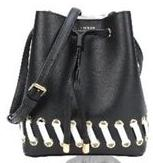

In [ ]:
# Let's try something else
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id_2 = [26754]
outfit_embedding_list_2 = []
for img_index in outfit_img_id_2:
  outfit_embedding_list_2.append(df_output.iloc[img_index, 2])

outfit_embedding_list_2 = np.array(outfit_embedding_list_2)
outfit_centroid_embedding_2 = centroid_embedding(outfit_embedding_list_2)
outfits_selected = df_output.iloc[outfit_img_id_2]

similar_images_df_2 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding_2, 6)

0.5342960357666016 ms


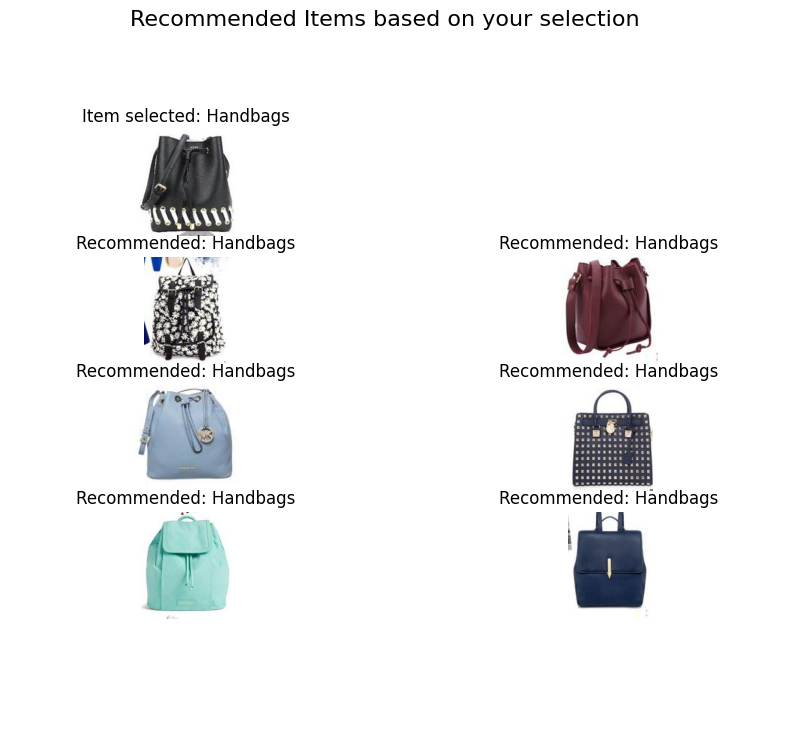

In [ ]:
# Usage with similar_images_df
visualize_images(similar_images_df_2)

24352


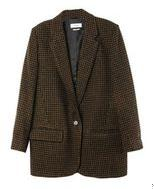

In [ ]:
# Let's look at another one
# Let's try something else
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id_3 = [24352]
outfit_embedding_list_3 = []
for img_index in outfit_img_id_3:
  outfit_embedding_list_3.append(df_output.iloc[img_index, 2])

outfit_embedding_list_3 = np.array(outfit_embedding_list_3)
outfit_centroid_embedding_3 = centroid_embedding(outfit_embedding_list_3)
outfits_selected = df_output.iloc[outfit_img_id_3]

similar_images_df_3 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding_3, 6)

0.5297660827636719 ms


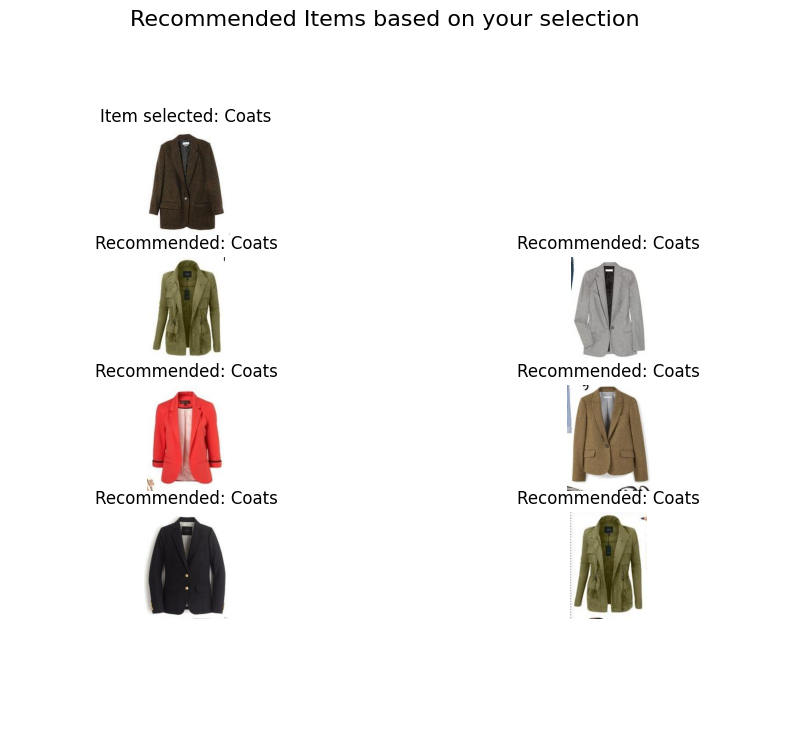

In [ ]:
# Usage with similar_images_df
visualize_images(similar_images_df_3)

8812


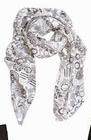

In [ ]:
# explore images
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id = [8812]
outfit_embedding_list_4 = []
for img_index in outfit_img_id:
  outfit_embedding_list_4.append(df_output.iloc[img_index, 2])

outfit_embedding_list_4 = np.array(outfit_embedding_list_4)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list_4)
outfits_selected = df_output.iloc[outfit_img_id]

similar_images_df_4 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 6)

0.5588531494140625 ms


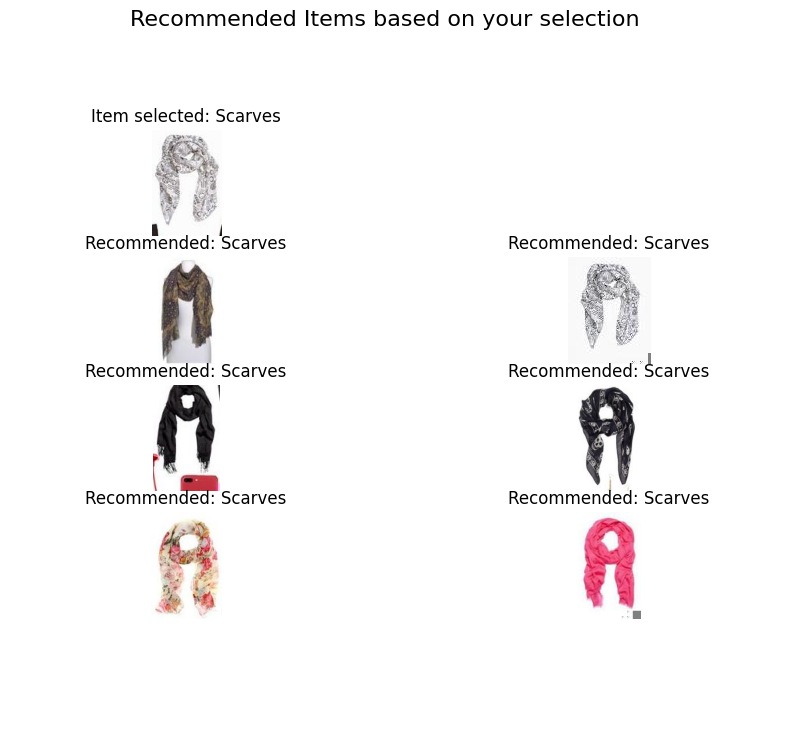

In [ ]:
# Usage with similar_images_df
visualize_images(similar_images_df_4)

<a name='6-2.2'></a>

##### 6.2.2 K @ 10

46537


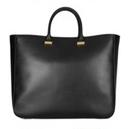

In [ ]:
# explore images
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id = [46537]
outfit_embedding_list_5 = []
for img_index in outfit_img_id:
  outfit_embedding_list_5.append(df_output.iloc[img_index, 2])

outfit_embedding_list_5 = np.array(outfit_embedding_list_5)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list_5)
outfits_selected = df_output.iloc[outfit_img_id]

similar_images_df_5 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 11)

0.61798095703125 ms


In [ ]:
def visualize_images_10(df):
    # Create a figure with two columns
    fig, axs = plt.subplots(6, 2, figsize=(10, 8))

    plt.suptitle("Recommended Items based on your selection", fontsize=16, y=1.03)

    # Display the item selected in the first column (column 0)
    selected_row = df.iloc[0]
    selected_img_path = selected_row.img_path
    selected_label = selected_row.label
    selected_img = mpimg.imread(selected_img_path)
    axs[0, 0].imshow(selected_img)
    axs[0, 0].set_title(f'Item selected: {selected_label}')
    axs[0, 0].axis('off')

    # Loop through the recommended items (remaining rows) and display them in the second column (column 1)
    recommended_items = list(df.iloc[1:].itertuples())
    for i, (row, ax) in enumerate(zip(recommended_items, axs[1:].flatten()), 1):
        img_path = row.img_path
        label = row.label
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f'Recommended: {label}')
        ax.axis('off')

    # Hide the empty subplots
    for i in range(5, 10):
        axs[i // 2, i % 2].axis('off')

    # Hide the axis line in the second column of the first row
    axs[0, 1].axis('off')

    # Show the images
    plt.show()

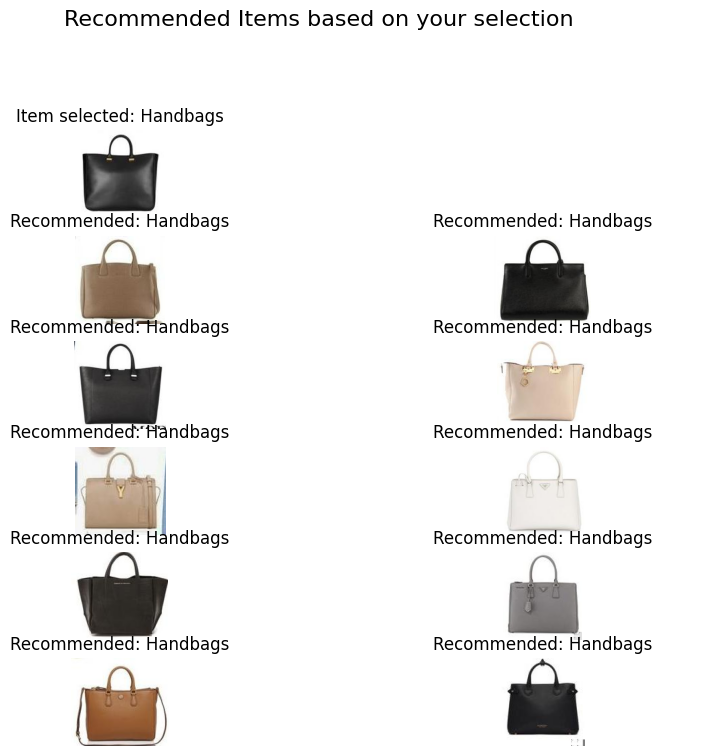

In [ ]:
# Usage with similar_images_df
visualize_images_10(similar_images_df_5)

43882


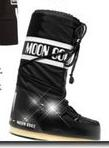

In [ ]:
# explore images
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id = [43882]
outfit_embedding_list_6 = []
for img_index in outfit_img_id:
  outfit_embedding_list_6.append(df_output.iloc[img_index, 2])

outfit_embedding_list_6 = np.array(outfit_embedding_list_6)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list_6)
outfits_selected = df_output.iloc[outfit_img_id]

similar_images_df_6 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 11)

0.6515979766845703 ms


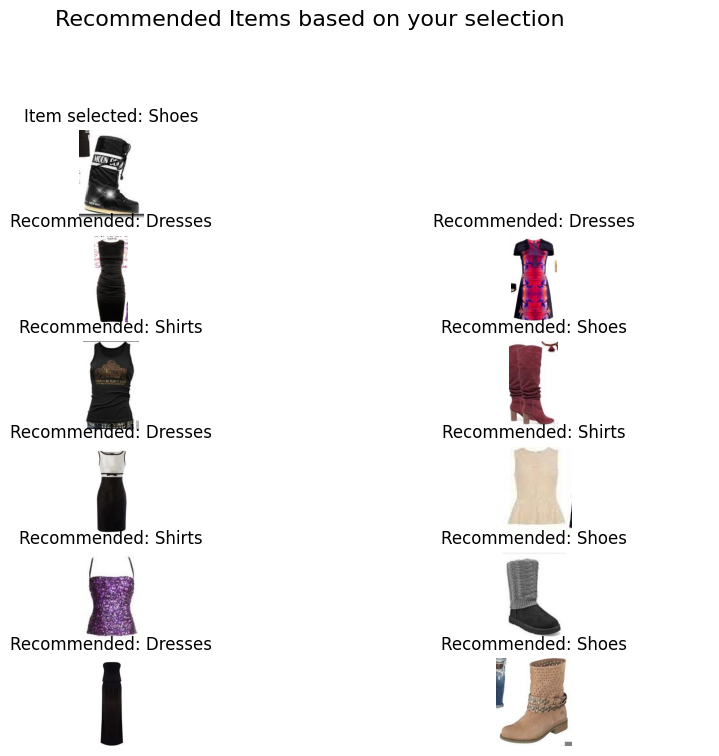

In [ ]:
# Usage with similar_images_df
visualize_images_10(similar_images_df_6)

31496


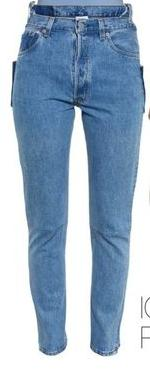

In [ ]:
# explore images
img_index = np.random.randint(len(df_output), size=1)[0]
print(img_index)
load_image(df_output.iloc[img_index, 0])

In [ ]:
outfit_img_id = [31496]
outfit_embedding_list_7 = []
for img_index in outfit_img_id:
  outfit_embedding_list_7.append(df_output.iloc[img_index, 2])

outfit_embedding_list_7 = np.array(outfit_embedding_list_7)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list_7)
outfits_selected = df_output.iloc[outfit_img_id]

similar_images_df_7 = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 11)

0.9572505950927734 ms


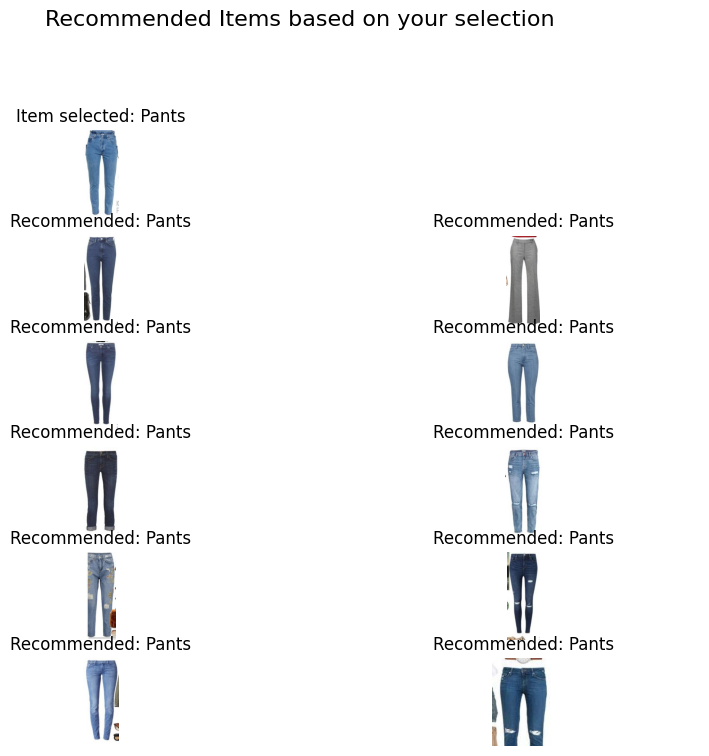

In [ ]:
# Usage with similar_images_df
visualize_images_10(similar_images_df_7)